# Modelo de Deteccion de Fraudes - Nala

Oversampling and under-sampling son técnicas para modificar la relación de clases un dataset desbalanceado que utilizamos para modelar. La librería "imblearn" ajusta las clases desbalanceadas optimizando los modelos de machine learning. Compararemos los resultados obtenidos de los siguientes métodos:


* Random Oversampling

* SMOTE (Synthetic Minority Oversampling Technique) Oversampling

* Random Under-Sampling

* Near Miss Under-Sampling

Primero que nada debemos detallar lo que es un modelo de clasificación desbalanceado, el cual también es llamado "modelado de eventos de rara ocurrencia". Por ejemplo, si solamente el 0,03% del dataset pertenece a la clase minoritaria, el modelo tiende a fallar cuando intenta identificar el patrón de las minorías, por el contrario elige casi siempre la mayoría.


Este tipo de modelos de rara ocurrencia tiene variados fines como diagnóstico de enfermedades, detección de fraudes, entre otros.



In [26]:
# Creating the modeling dataset
from sklearn.datasets import make_classification

# Data processing
import pandas as pd
import numpy as np
import json
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and performance
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Over sampling and under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from collections import Counter

In [27]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, \
RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score

from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import make_scorer, recall_score, confusion_matrix, \
precision_score, f1_score, accuracy_score, classification_report

In [28]:
data = pd.read_csv(r'DS Challenge.csv', sep=';')

In [29]:

data.fraude.replace(True,1,inplace=True)
data.fraude.replace(False,0,inplace=True)
data.is_prime.replace(True,1,inplace=True)
data.is_prime.replace(False,0,inplace=True)
data.genero.replace('F',0,inplace=True)
data.genero.replace('M',1,inplace=True)
data.genero.replace('--',0,inplace=True)

data.dispositivo = data.dispositivo.str.replace(';', ',', regex = False)
data.dispositivo = data.dispositivo.str.replace("'", '"', regex = False)
y = json.loads(data.dispositivo[1])
type(y)
data.dispositivo = data.dispositivo.apply(lambda  x : json.loads(x) if x != np.nan else x)


data['dispositivo_model'] = data.dispositivo.apply(lambda x : x['model'])
data['dispositivo_divice_score'] = data.dispositivo.apply(lambda x : x['device_score'])
data['dispositivo_os'] = data.dispositivo.apply(lambda x : x['os'])

data1=data
data1['fecha']=data['fecha']
data1['fecha'] =  pd.to_datetime(data1['fecha'], infer_datetime_format=True)
data['dia'] = data1['fecha'].apply(lambda x: x.day_name())


if(data['monto'].dtypes=='object'):
    data.monto = data.monto.str.replace(',', '.', regex = False) 
    data['monto'] = data['monto'].astype(float) 
if(data['dcto'].dtypes=='object'):
    data.dcto = data.dcto.str.replace(',', '.', regex = False) 
    data['dcto'] = data['dcto'].astype(float) 
if(data['cashback'].dtypes=='object'):
    data.cashback = data.cashback.str.replace(',', '.', regex = False) 
    data['cashback'] = data['cashback'].astype(float) 
if(data['ID_USER'].dtypes!='object'):
    data['ID_USER'] = data['ID_USER'].astype(int) 
if(data['fecha'].dtypes!='object'):
    data['fecha'] = data['fecha'].astype(str) 
    
data= data.drop(['dispositivo','fecha'], axis=1)
data['fraude'].value_counts(normalize = True)

def para_plotear(X_train_rus, y_train_rus):
    d2 = pd.DataFrame(data=y_train_rus) 
    x1=X_train_rus.loc[:, ['monto','linea_tc']]
    d1 = pd.DataFrame(data=x1)
    a=pd.merge(d1, d2, left_index=True, right_index=True)
    return a

El dataset tiene menos del 3% de fraudes, se considera desbalanceado y entra dentro de la categoría previamente mencionada.

In [31]:
data['fraude'].value_counts()

0.0    26165
1.0      810
Name: fraude, dtype: int64

In [33]:
data.head()

,ID_USER,genero,monto,hora,establecimiento,ciudad,tipo_tc,linea_tc,interes_tc,status_txn,is_prime,dcto,cashback,fraude,dispositivo_model,dispositivo_divice_score,dispositivo_os,dia
0,0,0,608.345633,20,Super,Merida,FÃ­sica,71000,51,Aceptada,0.0,60.834563,5.475111,0.0,2020,3,ANDROID,Tuesday
1,0,0,88.719243,7,NaN,Merida,Virtual,71000,51,Aceptada,0.0,0.000000,1.774385,0.0,2020,1,ANDROID,Wednesday
2,1,0,790.037653,11,NaN,Guadalajara,Virtual,94000,56,En proceso,0.0,0.000000,15.800753,0.0,2020,1,",",Friday
3,1,0,767.005387,11,MPago,Guadalajara,FÃ­sica,94000,56,Aceptada,0.0,0.000000,7.670054,0.0,2020,3,WEB,Sunday
4,1,0,254.171053,10,NaN,Guadalajara,FÃ­sica,94000,56,Aceptada,0.0,0.000000,2.541711,0.0,2020,3,%%,Thursday


Visualizaremos dos variables para observar la pequeña probabilidad de ocurrencia del fraude (color naranja).
Cabe destacar que se pueden plotear unicamente 2 variables , pero esto aplica para todas las descritas en el EDA a priori.

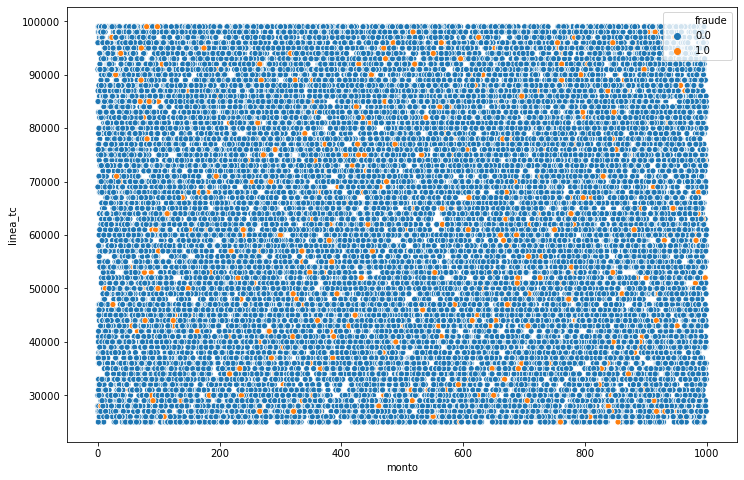

In [34]:
# Visualize the data
plt.figure(figsize=(12, 8))
sns.scatterplot( x='monto', y='linea_tc' ,hue = 'fraude', data = data)

In [35]:
data = pd.get_dummies(data, columns=None)
data.head()

,ID_USER,genero,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,...,"dispositivo_os_,",dispositivo_os_ANDROID,dispositivo_os_WEB,dia_Friday,dia_Monday,dia_Saturday,dia_Sunday,dia_Thursday,dia_Tuesday,dia_Wednesday
0,0,0,608.345633,20,71000,51,0.0,60.834563,5.475111,0.0,...,0,1,0,0,0,0,0,0,1,0
1,0,0,88.719243,7,71000,51,0.0,0.000000,1.774385,0.0,...,0,1,0,0,0,0,0,0,0,1
2,1,0,790.037653,11,94000,56,0.0,0.000000,15.800753,0.0,...,1,0,0,1,0,0,0,0,0,0
3,1,0,767.005387,11,94000,56,0.0,0.000000,7.670054,0.0,...,0,0,1,0,0,0,1,0,0,0
4,1,0,254.171053,10,94000,56,0.0,0.000000,2.541711,0.0,...,0,0,0,0,0,0,0,1,0,0


In [36]:
scaler = MinMaxScaler()
dat = scaler.fit_transform(data.values)
scaled = pd.DataFrame(dat, columns=data.columns)

# There are now x features, since we broke down categorical vars
scaled.tail()

,ID_USER,genero,monto,hora,linea_tc,interes_tc,is_prime,dcto,cashback,fraude,...,"dispositivo_os_,",dispositivo_os_ANDROID,dispositivo_os_WEB,dia_Friday,dia_Monday,dia_Saturday,dia_Sunday,dia_Thursday,dia_Tuesday,dia_Wednesday
26970,1.0,1.0,0.746249,0.545455,0.202703,0.75,0.0,0.00000,0.373249,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
26971,1.0,1.0,0.941881,0.636364,0.202703,0.75,0.0,0.00000,0.471097,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
26972,1.0,1.0,0.251198,0.454545,0.202703,0.75,0.0,0.00000,0.251290,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26973,1.0,1.0,0.024168,0.727273,0.202703,0.75,0.0,0.01213,0.010880,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
26974,1.0,1.0,0.517243,0.863636,0.202703,0.75,0.0,0.00000,0.258708,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train Test Split 

In [38]:
# Train test split
fraude = data['fraude']
scaled_df = scaled.drop(columns=['fraude'])

X_train, X_test, y_train, y_test = train_test_split(scaled_df, 
                                                    fraude, 
                                                    test_size=0.2, 
                                                    random_state=27 , 
                                                    stratify=fraude)

print('El numero de registros en el dataset de entrenamiento es de ', X_train.shape[0])
print('El numero de registros en el dataset de testeo es de ', X_test.shape[0])




El numero de registros en el dataset de entrenamiento es de  21580
El numero de registros en el dataset de testeo es de  5395


Revisamos la clase mayoritaria y minoritaria para el dataset de entrenamiento 

In [40]:
print(sorted(Counter(y_train).items()))

[(0.0, 20932), (1.0, 648)]


## Metrica para Evaluacion de Performance del Modelo 

Antes de generar el modelo , debemos decidir que metrica vamos a optimizar.

En general la metrica de performance mas critica suele ser "Recall" o "Precision" para la clase minoritaria. Especificamente en el contexto de deteccion de fraude , queremos maximizar el ratio de true positives y capturar la mayor cantidad de casos de fraude como sean posibles. En conclusion , la metrica "Recall" para la minoria es la que buscaremos optimizar.

Otro caso muy distinto podria ser la deteccion de spam , donde se busca minimizar la cantidad de falsos positivos, para evitar clasificar un mail importante como spam en muchas oportunidades, en ese caso la metrica a optimizar deberia ser "Recall"

# Modelo Base

Para dejar en evidencia todo lo comentado en palabras, procedemos a analizar el dataset de entrenamiento con un modelo de base de Random Forest, sin balanceado de clases minoritarias ni mayoritarias.

In [41]:

rf = RandomForestClassifier()
baseline_model = rf.fit(X_train, y_train)
baseline_prediction = baseline_model.predict(X_test)

# performance del modelo
print(classification_report(y_test, baseline_prediction))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5233
         1.0       0.00      0.00      0.00       162

    accuracy                           0.97      5395
   macro avg       0.48      0.50      0.49      5395
weighted avg       0.94      0.97      0.96      5395



C:\Users\agust\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))




La metrica Recall toma valores desde 0 a 1 , 0 representa 0% de verdaderos positivos (true positives) y 1 equivale a 100% de casos de verdaderos positivos.
Como vemos para la clase minoritaria , tiene 0% de recall, lo cual es pesimo.

# Random Over Sampling

Una forma de oversalmpling (sobremuestreo) es generar nuevas muestras de la clase minoritaria mediante el muestreo con reemplazo.

`RandomOverSampler` de `imblearn` library nos provee de esa funcion. Cabe destacar que se le aplica el oversampling al dataset de entrenamiento unicamente.

In [42]:

ros = RandomOverSampler(random_state=42)
X_train_ros, y_train_ros= ros.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_ros).items()))

[(0.0, 20932), (1.0, 20932)]


La clase minoritaria aumentó de 162 a 20932, igual que la mayoritaria.

A partir de la visualización, podemos ver más puntos de datos minoritarios de color naranja después del sobremuestreo aleatorio.

Text(0.5, 1.0, 'Random Over Sampling')

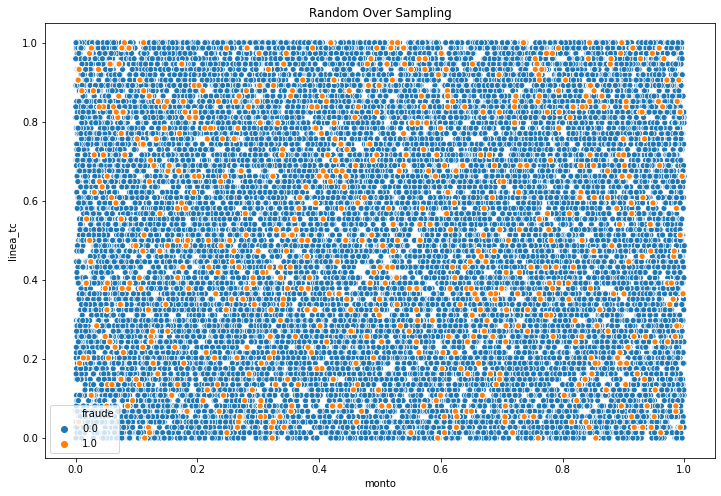

In [44]:
df_ros=para_plotear(X_train_ros,y_train_ros)


#Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'monto', y = 'linea_tc', hue = 'fraude', data = df_ros)
plt.title('Random Over Sampling')

Performance del oversampling

In [45]:

ros_model = rf.fit(X_train_ros, y_train_ros)
ros_prediction = ros_model.predict(X_test)


print(classification_report(y_test, ros_prediction))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5233
         1.0       0.00      0.00      0.00       162

    accuracy                           0.97      5395
   macro avg       0.48      0.50      0.49      5395
weighted avg       0.94      0.97      0.96      5395



C:\Users\agust\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Pese al ajuste sigue dando muy bajo el recall de la clase minoritaria, probemos otro metodo.

# SMOTE Oversampling

Probemos SMOTE (Synthetic Minority Oversampling Technique), publicado en 2002 por Chawla, Bowyer, Hall & Kegelmeyer [2]. En lugar de sobremuestrear aleatoriamente con reemplazo, SMOTE toma cada muestra minoritaria e introduce puntos de datos sintéticos que conectan la muestra minoritaria y sus vecinos más cercanos. Los vecinos de los k vecinos más cercanos se eligen aleatoriamente.

In [46]:

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote= smote.fit_resample(X_train, y_train)

print(sorted(Counter(y_train_smote).items()))

[(0.0, 20932), (1.0, 20932)]



Similar al random oversampling, la categoría minoritaria aumentó de 162 a 20932 después del sobremuestreo SMOTE.

Text(0.5, 1.0, 'SMOTE Over Sampling')

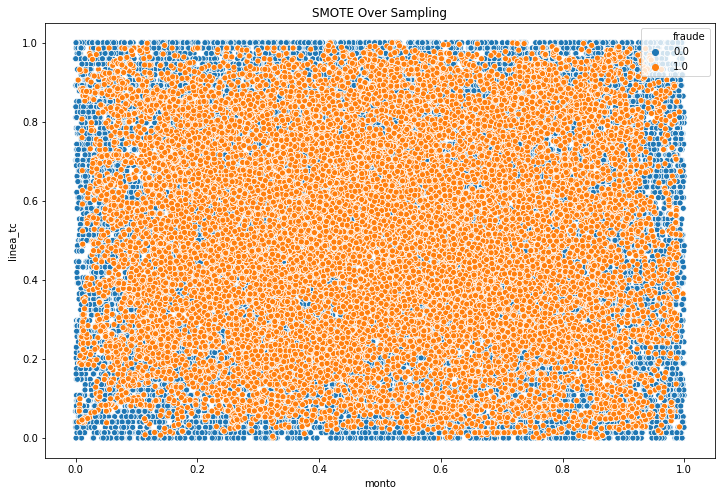

In [47]:
df_smote=para_plotear(X_train_smote,y_train_smote)


# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'monto', y = 'linea_tc', hue = 'fraude', data = df_smote)
plt.title('SMOTE Over Sampling')

Ahora ejecutemos el mismo modelo de Random Forest en el conjunto de datos SMOTE y verifiquemos su rendimiento.

In [48]:

smote_model = rf.fit(X_train_smote, y_train_smote)
smote_prediction = smote_model.predict(X_test)

# Vemos como performan las metricas
print(classification_report(y_test, smote_prediction))

              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98      5233
         1.0       0.00      0.00      0.00       162

    accuracy                           0.97      5395
   macro avg       0.48      0.50      0.49      5395
weighted avg       0.94      0.97      0.96      5395



C:\Users\agust\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Podemos observar que la metrica Recall para la clase minoritaria sigue dando muy baja.

# Random Under-Samplling

Random under-sampling elige al azar puntos de datos de la clase mayoritaria. Después del muestreo, la clase mayoritaria tiene el mismo número de puntos de datos que la clase minoritaria.

In [49]:

rus = RandomUnderSampler(random_state=42)
X_train_rus, y_train_rus= rus.fit_resample(X_train, y_train)


print(sorted(Counter(y_train_rus).items()))

[(0.0, 648), (1.0, 648)]


Ahora random under-sampling ha disminuídi la cantidad de muestras de la clase mayoritaria de 5233 a 648 .

La visualización muestra que tenemos menos puntos de datos para el modelo.

Text(0.5, 1.0, 'Random Under Sampling')

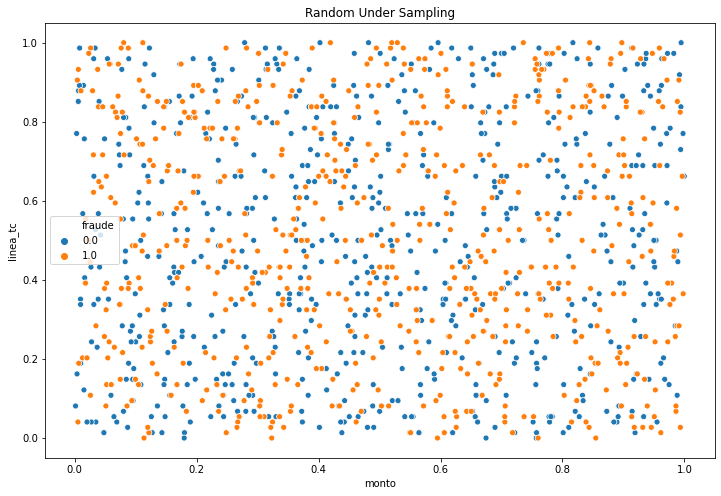

In [50]:
df_rus=para_plotear(X_train_rus,y_train_rus)


# Plot the chart
plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'monto', y = 'linea_tc', hue = 'fraude', data = df_rus)
plt.title('Random Under Sampling')

In [52]:

rf = RandomForestClassifier()
rus_model = rf.fit(X_train_rus, y_train_rus)
rus_prediction = rus_model.predict(X_test)

print(classification_report(y_test, rus_prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.50      0.66      5233
         1.0       0.03      0.47      0.05       162

    accuracy                           0.50      5395
   macro avg       0.50      0.49      0.36      5395
weighted avg       0.94      0.50      0.64      5395



Al disminuir la cantidad de muestras de la clase mayoritaria, la metrica Recall para la clase minoritaria ha incrementado en 0,47 . 

# Under Sampling Using NearMiss

`NearMiss` de la libreria`imblearn` usa KNN (K Nearest Neighbors) para obtener un submuestreo.

Si nos enfocamos en las datasheets obtenemos las 3 diferencias puntuales entre sus versiones :

" Differences of the three versions:
* "NearMiss-1 selects the positive samples for which the average distance to the N closest samples of the negative class is the smallest."
* "NearMiss-2 selects the positive samples for which the average distance to the N farthest samples of the negative class is the smallest."
* "NearMiss-3 is a 2-steps algorithm. First, for each negative sample, their M nearest-neighbors will be kept. Then, the positive samples selected are the one for which the average distance to the N nearest-neighbors is the largest.""

Implementaremos la version 3 por ser la mejor performante para este caso .


In [53]:

nearmiss = NearMiss(version=3)
X_train_nm, y_train_nm= nearmiss.fit_resample(X_train, y_train)


print(sorted(Counter(y_train_nm).items()))

[(0.0, 648), (1.0, 648)]


La visualización muestra el patrón del submuestreo de NearMiss.

Text(0.5, 1.0, 'NearMiss Under Sampling')

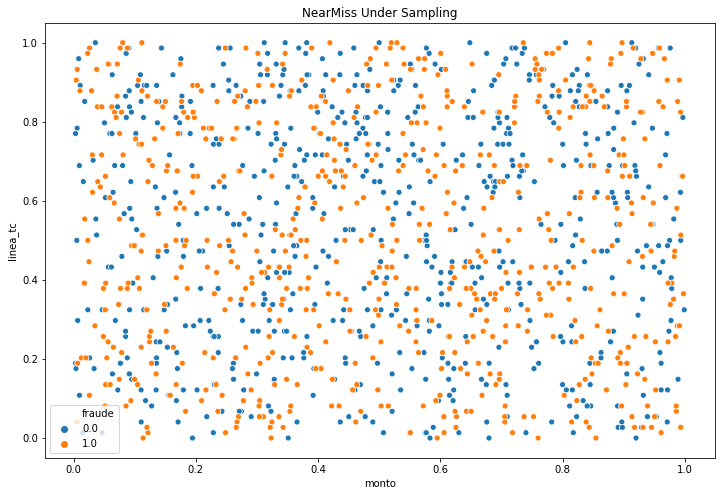

In [54]:
df_nm=para_plotear(X_train_nm,y_train_nm)


plt.figure(figsize=(12, 8))
sns.scatterplot(x = 'monto', y = 'linea_tc', hue = 'fraude', data = df_nm)
plt.title('NearMiss Under Sampling')

In [55]:

rf = RandomForestClassifier()
nearmiss_model = rf.fit(X_train_nm, y_train_nm)
nearmiss_prediction = nearmiss_model.predict(X_test)
importance = rf.feature_importances_
#Observamos las performances de las metricas en cuestion
print(classification_report(y_test, nearmiss_prediction))

              precision    recall  f1-score   support

         0.0       0.97      0.41      0.58      5233
         1.0       0.03      0.60      0.06       162

    accuracy                           0.42      5395
   macro avg       0.50      0.51      0.32      5395
weighted avg       0.94      0.42      0.57      5395



`NearMiss` nos da un valor de Recall de 0,60 . La cual es la mas Alta de todo el modelado de los 4 metodos . Siendo esta ultima la definitiva.

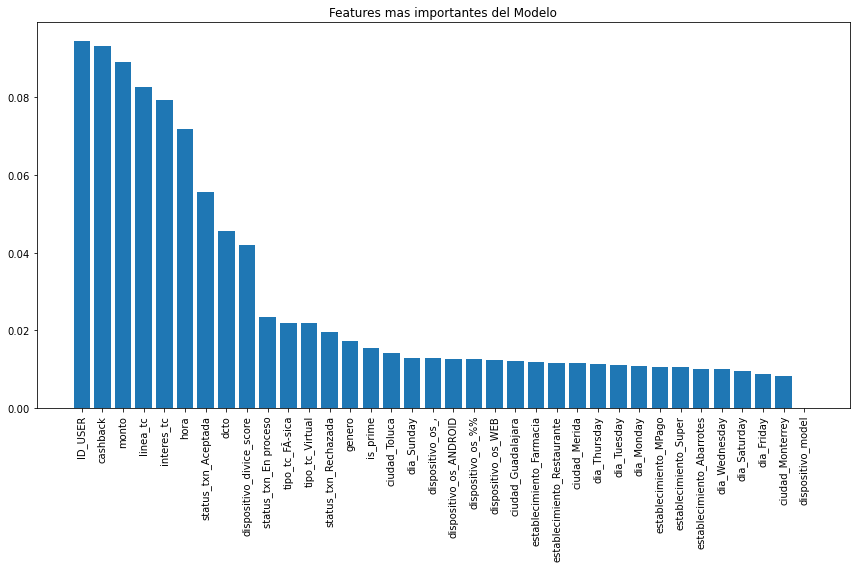

In [57]:
sorted_indices = np.argsort(importance)[::-1] 
plt.figure(figsize=(12, 8))
plt.title('Features mas importantes del Modelo')
plt.bar(range(X_train.shape[1]), importance[sorted_indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_indices], rotation=90)
plt.tight_layout()
plt.show()

Estas son las Features mas importante del modelo, aquellas variables que mas inciden en la deteccion de fraudes . Siendo las mas importantes "ID_USER" , "Cashback" y "Monto" . Como indica el proximo grafico .

# Conclusión - Modelo de Deteccion de Fraude

Es importante hacer un breve resumen señalando que estos métodos específicos nos permitieron abordar una problemática muy particular. 

La detección de fraude por su característica implícita genera que cualquier modelo elija casi siempre la clase mayoritaria, no imputando casi ningún verdadero positivo. Es ahí donde tome mucha fuerza la métrica recall , tambien llamada Exhaustividad, que nos cuestiona ¿qué porcentaje de los fraudes somos capaces de identificar?. En nuestro caso ese valor es alto, un 60%. Este valor se obtiene de dividir los true positive(TP) con la suma de TP y los falsos negativos(FN) .

Como trade-off en este caso particular,  la alta exhaustividad o Recall, lleva en consecuencia un número muy bajo de F1 , por ser la métrica de precisión casi un 3% . Entonces lo que generamos pudiendo detectar el 60% de los fraudes del total, se contrapone al derrochar muchos recursos identificándolos . El modelo es muy poco preciso , va a marcar como fraude a muchas transacciones que no la son ,pero característica que estamos dispuestos a intercambiar.


# Referencias

* [1] [imbalanced learn documentation](https://imbalanced-learn.org/stable/install.html)
* [2] [SMOTE: Synthetic Minority Over-sampling Technique](https://arxiv.org/abs/1106.1813)
* [3] [NearMiss](https://www.scirp.org/(S(351jmbntvnsjt1aadkposzje))/reference/ReferencesPapers.aspx?ReferenceID=1603053)